# Magnetic Resonance Imaging

## Introduction



The objective of this notebook is to review different concepts of Magnetic Resonance Imaging as well as work with an MR image to process and obtain some information. 

1. Study the concept of T1 and T2 relaxation times through the processing of MR images
2. Open an MR image and review the metadata to determine the type of sequence that was used for acquisition
3. Segment an MR image and obtain automatic measurements on a segmented organ 


## MR image acquisition parameters

There are multiple MR acquisition parameters that are defined for the sequence and it is possible to inspect the value of them analyzing the metadata in the DICOM file. We will here list some of those parameters after inspection of the metadata. We usually distinguish between *geometry* and *acquisition* parameters.

In [1]:
!pip install pydicom

/tmp/ipykernel_234/4108869639.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x, y, np.flipud(ArrayDicom)) #flipud: Flip array in the up/down direction, pcolormesh


(0.0, 511.0, 0.0, 511.0)

<Figure size 432x288 with 0 Axes>

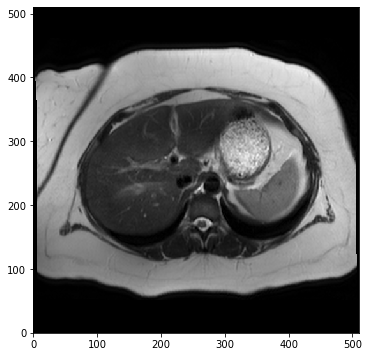

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pydicom

# Get file from DICOM file
RefDs = pydicom.read_file('Source Files/IM_0028.dcm') 
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns)) 
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype) #creating an array with the image size and type
ArrayDicom[:,:]=RefDs.pixel_array

plt.figure()
plt.figure(figsize=(6,6))
plt.axes().set_aspect('equal') #this makes the image square
plt.set_cmap(plt.gray()) #grayscale
x=np.arange(RefDs.Rows)
y=np.arange(RefDs.Columns)

plt.pcolormesh(x, y, np.flipud(ArrayDicom)) #flipud: Flip array in the up/down direction, pcolormesh
plt.axis([x.min(),x.max(),y.min(),y.max()])

In [4]:
#inspecting the metadata 
print(RefDs)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 204
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.46.670589.11.3397498352.605445821.304410668.1378834227
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.46.670589.11.0.0.51.4.32.0
(0002, 0013) Implementation Version Name         SH: 'Philips MR 32.0'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M_SE', 'M', 'SE']
(0008, 0012) Instance Creation Date              DA: '20120101'
(0008, 0013) Instance Creation Time              TM: '122531'
(0008, 0014) Instance Creator UID                UI: 1.3.46.670589.11.2501

In [5]:
print('Geometry Parameters:')
print('Image is '+str(RefDs.Rows)+'x'+str(RefDs.Columns)+' pixels')
print('The slice thickness is '+str(RefDs.SliceThickness)+' mm with '+ str(RefDs.SpacingBetweenSlices)+' mm between slices')
print('The patient was in '+RefDs.PatientPosition+' position')
print('Pixels are spaced '+str(RefDs.PixelSpacing[0])+' mm horizontally and '+str(RefDs.PixelSpacing[1])+' vertically')
print('\n')
print('Acquisition Parameters:')
print('TE (echo time) = '+str(RefDs.EchoTime)+' ms')
print('TR (repetition time) = '+str(RefDs.RepetitionTime)+' ms')
print('Number of Averages = '+str(RefDs[0x0018,0x0083].value))
print('ETL (echo train length) = '+str(RefDs.EchoTrainLength))
print('Acquisition Contrast is '+RefDs[0x2005,0x140f].value[0].AcquisitionContrast)
print('Sequence is '+RefDs[0x2005,0x140f].value[0].PulseSequenceName)
if (RefDs[0x2005,0x140f].value[0].MultipleSpinEcho=='YES'):
    print('It is a multi-echo acquisition')
print('The transmission was made with '+RefDs[0x2005,0x140f].value[0].TransmitCoilType+' coil')
print('The reception was made with '+RefDs[0x2005,0x140f].value[0].ReceiveCoilType+' coil')


Geometry Parameters:
Image is 512x512 pixels
The slice thickness is 7 mm with 8 mm between slices
The patient was in HFS position
Pixels are spaced 0.732421875 mm horizontally and 0.732421875 vertically


Acquisition Parameters:
TE (echo time) = 80 ms
TR (repetition time) = 1334.84313964843 ms
Number of Averages = 1
ETL (echo train length) = 63
Acquisition Contrast is T2
Sequence is TSE
It is a multi-echo acquisition
The transmission was made with BODY coil
The reception was made with MULTICOIL coil


### Activity 1 - Replot the image with a title made by the sequence parameters

Tip: The format for a sequence is: [AAA, T#-weighted, TE=##, TR=##, ETL=###, NEX=##], where AAA is the name of the sequence, T#-weighted is the contrast, NEX is the number of averages.

In [6]:
# Write code for Activity 1
# HERE



## T1 and T2 relaxation time

As we discussed before the contrast in MR imaging depends on the intrinsic characteristics of the tissues called T1 and T2 relaxation time. When tissues are placed in a strong magnetic field the protons will precess aligned along this field and if an external Radio Frequency pulse is applied the protons alignment will be disturbed and the nuclei will eventually return to their equilibrium and emit RF energy. The constant describing the time for the longitudinal magnetization to return to 63% of its initial equilibrium value is called the spin-lattice relaxation time, or T1. The constant describing the time for the transverse magnetization to rotate at different angular frequencies and eventually loose their net transverse magnetization and reach 37% of its equilibrium value value is called the spin-spin relaxation time, or T2. 

It is possible to measure the T1 and T2 relaxation time of a sample by acquiring a series of images at different echo times. To obtain the T1 relaxation time an inversion recovery (IR) sequence is used. For the T2 relaxation time we can use a spin echo (SE) sequence.

The signal intensity as a function of the echo time (TE) on a multi-echo spin-echo sequence can be fitted to

$$M_{xy} (TE) = M_0 exp\left(\frac{−T_E}{T_2}\right)$$

Where $M_{xy}$ is the signal intensity measured at the echo time TE and we fit $M_0$ and $T_2$. 

The signal intensity as a function of the inverstion time (TI) on multiple inversion recovery acquisitions can be fitted to

$$M_z (TI) = M_0 \left( 1-exp \left (\frac{-T_I}{T_1} \right) \right)$$

Where $M_{z}$ is the signal intensity measured at the inverstion time $T_I$ and we fit $M_0$ and $T_1$. 

### T1 using Inversion Recovery Acquisition

In the following example we will plot the signal obtained from samples that we know have different T1 relaxation times. This was ensured by using a different concentration of water and a paramagnetic agent (Gadolinum), which accelerates the relaxation of protons. 

A series of images were obtained in an MR scanner using an inversion recovery sequence with different IR time. The function of the inverting pulse is to flip the initial longitudinal magnetization ($M_0$) of all tissues in the imaged slice or volume to point opposite to the direction of the main magnetic field (inversion). During the TI interval, these inverted tissues undergo T1 relaxation to go back to equilibrium, during this process a time occurs where the $M_z$ of each tissue passes through zero. If TI is set to that particular value (and signal acquisition is made at that point), the tissue passing through zero will produce no signal and be effectively suppressed or "nulled".

| $~$ |
|:---: |
| <img src="IRFigure.gif" width=380> |

If we focus in one single sample (look at the first row samples in columns 5 and 6) and observe that the intensity starts at a bright value then passes by zero and reaches again a bright value. It is at this point of zero when we know that we have eequalized the TI with the $T_1$. We can see this in the zoom for that region on the right. Each column is a repeat but each row has a different concentration of a paramagnetic substance that affects T1.

In [8]:
from ipywidgets import interact

indexes=np.arange(1,41,3)   #the indexes for these figures are from 1 to 41 by 3s

def TIImages(Series):
    plt.figure()
    plt.figure(figsize=(6,6))
    fname='Source Files/T1Images/IM_{:04d}'.format(indexes[Series])
    RefDs = pydicom.read_file(fname)
    ArrayDicom=RefDs.pixel_array
    plt.subplot(121)
    plt.set_cmap(plt.gray()) #grayscale
    plt.imshow(ArrayDicom) 
    plt.subplot(122)
    plt.set_cmap(plt.gray()) #grayscale
    plt.imshow(ArrayDicom[70:140,100:145])
    plt.show()
    
interact(TIImages,Series=(0,13));

interactive(children=(IntSlider(value=6, description='Series', max=13), Output()), _dom_classes=('widget-inter…

In the following cell we will open all the images and obtain a sub-image for three samples only. We will then segment those samples and obtain the average of the signal at all the different inversion times and graph as a function of the inversion time the average intensity. We should thus see the T1 relaxation of these samples and at which point they are nulled or cross zero. Note that the image in the MRI is never negative, so we will flip any magnitude that appears "before" the minimum value to obtain the relaxation curve.

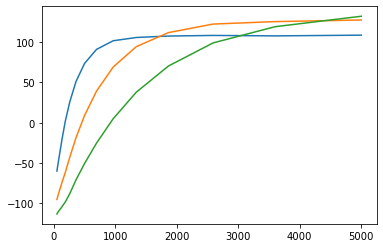

In [10]:
import cv2

AnalyzedSamples=np.zeros((14,70,23))   #sub-array of 14 images, 70x23 pixels large (only three samples) to be analyzed
Values=np.zeros((3,14))    #to store the mean values of intensity
TIs=np.zeros((14))  #to store inversion times (obtained from DICOM file)
Threshold=200  #simple segmentation of those samples using thresholding

for files in range(0,14):   #we know that there are 14 files
    fname='Source Files/T1Images/IM_{:04d}'.format(indexes[files])
    RefDs = pydicom.read_file(fname)
    TIs[files]=RefDs[0x5200, 0x9230].value[0][0x2005, 0x140f].value[0].InversionTime
    ArrayDicom=RefDs.pixel_array
    AnalyzedSamples[files,:,:]=ArrayDicom[70:140,100:123]  #this takes only three of the samples for analysis
    ixmask=np.where(AnalyzedSamples[0]>Threshold)
    mask=np.zeros(np.shape(AnalyzedSamples[files]),'uint8')
    mask[ixmask]=1
    ret, markers = cv2.connectedComponents(mask)
    for regions in range(0,3):
        RegionMask=np.zeros(np.shape(AnalyzedSamples[files]),'uint8')
        RegionMask[np.where(markers==regions+1)]=1
        RegionImage=RegionMask*AnalyzedSamples[files]
        Values[regions,files]=np.mean(RegionImage)

for regions in range(0,3):
    MIN=np.argmin(Values[regions,:])
    Values[regions,:MIN]*=-1
    plt.plot(TIs,Values[regions,:])

### Activity 2 - Copy the code cell above and modify the plot:
#### 1. Add a legend to each plot 
#### 2. Add an adequate label to the x axis (with units)
#### 3. Answer the following question: if adding gadolinium to a sample makes it relax faster, which of the samples is the one with the highest concentration of gadolinum?

**Answer question 3 here**



In [11]:
# Add code for Activity 2
# HERE



## T2 using Multi-Echo Spin-Echo Acquisition

In a similar way we can also plot the T2 relaxation of samples with different relaxation times. The difference is that we would have to use a series of images obtained using a spin echo sequence with different TE time. This acquisition is called a multi-echo spin-echo and allows to obtain multiple images at different echo times. The spins are only as usual excited by a 90-degree pulse followed by a 180-degree refocusing pulse and an acquisition at the desired TE. We know then that at that point the intensity will be depend on how much transverse relaxation remains. If we continuously apply a series of 180-degree refocusing and TE acquisitions we can acquire multiple images at different time points to probe for the signal as a function of the transverse relaxation. That would provide then the curve for T2 relaxation.

| $~$ |
|:---: |
| <img src="Figures/MESEFigure.gif" width=380> |


In this example the samples had a super paramagnetic iron oxide (SPIO) added to them to modify their T2 relaxation tie. This time we will focus on four samples (look at the first column) and observe that the intensity starts at a bright value then decreases in value over time. This is the transverse relaxation expected from being in phase until no signal is seen while the spins dephase over time depending on their T2.

In [13]:
from ipywidgets import interact

indexes=np.arange(1,33,1)   

def TIImages(Series):
    plt.figure()
    plt.figure(figsize=(6,6))
    fname='Source Files/T2Images/IM_{:04d}'.format(indexes[Series])
    RefDs = pydicom.read_file(fname)
    ArrayDicom=RefDs.pixel_array
    plt.subplot(121)
    plt.set_cmap(plt.gray()) #grayscale
    plt.imshow(ArrayDicom) 
    plt.subplot(122)
    plt.set_cmap(plt.gray()) #grayscale
    plt.imshow(ArrayDicom[100:270,110:143])
    plt.title(fname)
    plt.show()
    
interact(TIImages,Series=(0,len(indexes)-1));

interactive(children=(IntSlider(value=15, description='Series', max=31), Output()), _dom_classes=('widget-inte…

In the following cell we will open all the images and obtain a sub-image for four samples only (first column). We will then segment those samples and obtain the average of the signal at all the different echo times and graph as a function of the echo time the average intensity. We should thus see the T2 relaxation of these samples and how the signal will go from bright to zero exponentially.

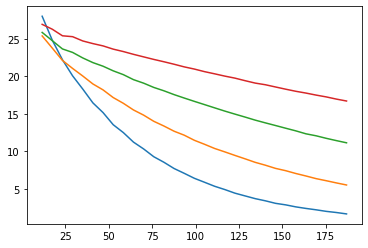

In [14]:
import cv2

AnalyzedSamples=np.zeros((len(indexes),170,33))   #sub-array of 31 images, 170x33 pixels large (four samples) to be analyzed
Values=np.zeros((4,len(indexes)))    #to store the mean values of intensity
TEs=np.zeros((len(indexes)))  #to store inversion times (obtained from DICOM file)
Threshold=200  #simple segmentation of those samples using thresholding

for files in range(0,len(indexes)):   
    fname='Source Files/T2Images/IM_{:04d}'.format(indexes[files])
    RefDs = pydicom.read_file(fname)
    TEs[files]=RefDs.EchoTime
    ArrayDicom=RefDs.pixel_array
    AnalyzedSamples[files,:,:]=ArrayDicom[100:270,110:143]  #this takes only three of the samples for analysis
    ixmask=np.where(AnalyzedSamples[0]>Threshold)
    mask=np.zeros(np.shape(AnalyzedSamples[files]),'uint8')
    mask[ixmask]=1
    ret, markers = cv2.connectedComponents(mask)
    for regions in range(0,4):
        RegionMask=np.zeros(np.shape(AnalyzedSamples[files]),'uint8')
        RegionMask[np.where(markers==regions+1)]=1
        RegionImage=RegionMask*AnalyzedSamples[files]
        Values[regions,files]=np.mean(RegionImage)

for regions in range(0,4):
    plt.plot(TEs[1:],Values[regions,1:])

### Activity 3 - Copy the code cell above and modify the plot:
####1. Add a legend to each plot
####2. Add an adequate label to the x axis (with units)
####3. If adding SPIO to a sample makes it relax faster, which of the samples is the one with the highest concentration of SPIO?

**Answer question 3 here**



In [15]:
# Add code for Activity 3
# HERE



## Image Segmentation

Image segmentation is the process of dividing an image into multiple parts. This is typically used to identify objects or other relevant information in digital images. 

In medical applications, it is used to subdivide images according to the tissue type or anatomy, in image guided surgery, surgical simulation, therapy evaluation and so on.

There are many methods to perform image segmentation, and we had reviewd very simple techniques in the **Image Processing** notebool. Here, we will be exploring a more advanced technique that is named **GrabCut algorithm**. We will then use the technique to segment the liver out of an abdominal MRI and we will determine the following:

1. The mean intensity value of the liver in the image
2. The signal-to-noise ratio of the liver region
3. The maximum intensity value in the liver
4. The area of the liver 


  The GrabCut algorithm is a method to execute 2D segmentation in an image that is very user friendly. The user only need to initially define a general region of foreground and background. Typically, this is done by drawing a rectangle around the object of interest.

  The manner that this is accomplish technically is by utilizing a combination of Graph Cuts and statistical models of the foreground and background structure in the color space. [1]

  The initial information given about the foreground and the background is used to create a model that we can use to determine if the unknown pixels are either foreground or background.
  
  In the GrabCut algorithm this is done by creating K components of multivariate Gaussian Mixture Models (GMM) for the two regions. GMM's are a parametric probability density function represented as a weighted sum of Gaussian component densities. 
  A Gaussian mixture model is a weighted sum of $M$ component Gaussian densities as given by the equation [2],

$$p(x | \lambda)=\sum^{i=1}_{M}\omega_{i} g(x | \mu_{i},\sigma_{i})$$
 
 where x is a D-dimensional continuous-valued data vector, $w_{i}, i = 1, . . . , M$, are the mixture weights, and $g(x|\mu_i, \sigma_{i}), i = 1, . . . , M,$ are the component Gaussian densities. Each component density is a D-variate
Gaussian function of the form,

$$g(x | \mu_{i},\sigma_{i}) = \frac{1}{\sqrt((2\pi)^{D}\sigma_{i})}\exp\{{-\frac{1}{2}}\frac{((x-\mu_i)'(x-\mu_i))}{\sigma_{i}}\}$$

with mean vector $\mu_i$ and covariance matrix $\sigma_i$. The mixture weights satisfy the constraint that $\sum^{M}_{i=1}\omega_i=1$. 

The complete Gaussian mixture model is parameterized by the mean vectors, covariance matrices and mixture weights from all component densities. These parameters are collectively represented by the notation, $\lambda=\{\omega_i, \mu_i, \sigma_i\}$, $i= 1,..., N$

The GMM components have the same dimensions as the image space and are derived from the intensity statistics in each cluster. In order to get good a segmentation it is better to find components with low variance since this makes the cluster easier to separate from the others. 

The basic steps for the GrabCut algorithm are as follows:


1. The user inputs three parameters: foreground, background, and unknown part of the image
2. The computer creates an initial image segmentation
3. The foreground and background are modeled as Gaussian Mixture Models (GMMs) using the Orchard-Bouman clustering algorithm
4. Every pixel in the foreground is assigned to the most probable Gaussian component in the foreground GMMs. The same process is done with the pixels in the background
5. New GMMs are learned from the pixel sets that where created in the previous step
6. A graph is built and Graph Cut is used to find a new classification of foreground and background pixels
7. Repeat step 4-6 until the classification converges

Text(0.5, 1.0, 'Segmented Image')

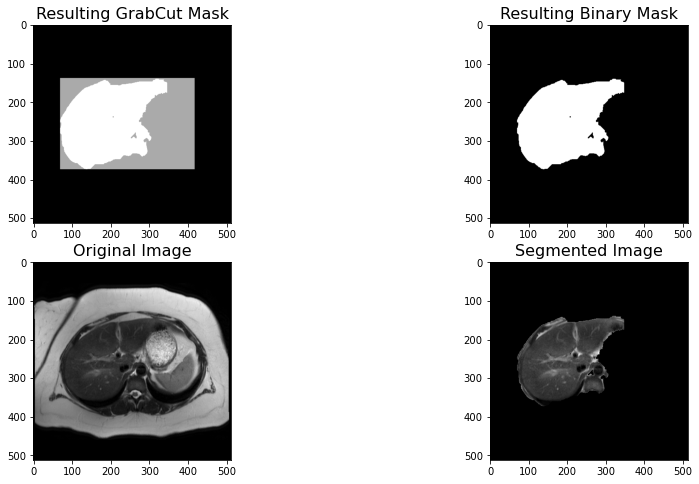

In [17]:
import cv2     #this module has the GrabCut implementation

RefDs = pydicom.read_file('Source Files/IM_0028.dcm') 
ArrayDicom=RefDs.pixel_array

matplotlib.image.imsave('AbdomenImage.png', ArrayDicom) #Saving the DICOM Array in a .png format to converto to RGB
img1=cv2.imread("AbdomenImage.png")  #Reading the png file, the grabgut function requires an RGB 
mask = np.zeros(img1.shape[:2],np.uint8) #Setting the size of the mask as the size of the image; [:2] to access dimensions

bgdModel = np.zeros((1,65),np.float64) #Temporary array for the background model
fgdModel = np.zeros((1,65),np.float64) #Temporary array for the foreground model

# We define an initial rectangle within the figure, we will set it at fixed coordinates (70,137) and fixed size 348x236
# This dimenssion of rectangle was obtained by trial and error observing the result of the segmentation 
rect = (70,137,348,236) # rect=(start_x, start_y, width, height) 

# grabCut requires the image, the mask, initial rectangle, the background and foreground models, 
# number of iterations and the mode where the modes can be
# GC_INIT_WITH_RECT to initialize the state and the mask using the provided rectangle
# GC_INIT_WITH_MASK to initialize the state with the provided mask
# GC_EVAL to make the algorithm resume from last iteration
# GC_EVAL_FREEZE_MODEL  to make the algorithm just run the grabCut algorithm for a single iteration with the fixed model
cv2.grabCut(img1,mask,rect,bgdModel,fgdModel,10,cv2.GC_INIT_WITH_RECT)

fig=plt.figure()
fig.set_size_inches((15,8))

# the resulting mask 
plt.subplot(221)
plt.imshow(mask) #Showing all the masks obtained
plt.title("Resulting GrabCut Mask",fontsize=16)

# making a binary mask to cut the segmented part from the original image only using the sure foreground
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8') #removes from the mask sure and probable background
# mask==0: Areas of sure background 
# mask==1: Areas of sure foreground 
# mask==2: Areas of probable background 
# mask==3: Areas of probable foreground 

# the resulting binary mask 
plt.subplot(222)
plt.imshow(mask2) #Showing the foreground mask 
plt.title("Resulting Binary Mask",fontsize=16)

img = img1[:,:,1]*mask2 #Appling the mask to the image 

plt.subplot(223)
plt.imshow(img1) #Showing original image 
plt.title("Original Image",fontsize=16)
#plt.colorbar(),plt.show()
plt.subplot(224)
plt.imshow(img) #segmented image for the liver region
plt.title("Segmented Image",fontsize=16)

## Parameter Extraction

After segmentation it is possible to make automatic parameter extraction from the liver image. Using the mask we will have only the pixels corresponding to the liver. We can then calculate the average, maximum and minimum intensity of the liver pixels. We can also calculate the area of the liver from the total pixels in this segment and the area of each pixel.

In the following code I will provide those first three parameters:

In [18]:
#Calculating the mean intensity of the liver in the image utilyzing the mask obtained from the GrabCut Algorithm

intensity = img[np.where(mask2==1)] #Creating an array that contain only the LIVER pixels 
print('The mean intensity of the LIVER region is: '+str(intensity.mean())) #array.mean() calculates the mean intensity
print('The maximun intensity value in the LIVER is: '+str(np.max(intensity)))
print('The minimum intensity value in the LIVER is: '+str(np.min(intensity)))
print('The total liver pixels are: '+str(len(intensity)))


The mean intensity of the LIVER region is: 48.623607079314546
The maximun intensity value in the LIVER is: 185
The minimum intensity value in the LIVER is: 0
The total liver pixels are: 42716


### Activity 4 Write code below to calculate the area of the liver in $cm^2$

In [19]:
# Add code for Activity 4
# HERE



The **Signal-to-noise ratio** or **SNR** in images is defined as 
$$SNR=\frac{\mu_{signal}}{\sigma_{noise}}$$

We can then calculate the SNR or the liver area after segmentation. We require only to define an area as noise and this can typically be a square at the top of the image where we know there is no signal, or anything below a defined threshold.

In [20]:
# Calculating The signal-to-noise ratio of the liver region
threshold=20 # We will use a threshold for the noise, everything below 15 will be considered noise
noise = img1[np.where(img1[:,:,0] < threshold)] #Creating an array with the noise pixels 

standard_deviation=noise.std() #array.std() calculates the standard deviation of an array
SNR=intensity.mean()/standard_deviation #SNR = mean intensity of the liver divided by the standard deviation of the noise

print('The SNR of the LIVER region is: '+str(SNR)+' or '+str(int(20*np.log10(SNR)))+'dB')

The SNR of the LIVER region is: 12.469343271102208 or 21dB


### Activity 5 - Add a code cell below to calculate SNR if we define the noise as all the pixels in an 90x90 pixel square in the top left corner of the image

In [21]:
# Add code for Activity 5
# HERE



## Summary

In this example we:

* Inspected the metadata of an MR image and how it relates to acquisition parameters
* Analyze the T1 and T2 relaxation time of samples in the MRI
* Segmented an MR image with a GrabCut algorithm
* Use segmented images to calculate SNR automatically

Comments and corrections welcome!

## Assignment 7

* Complete the 5 Activities in the notebook and upload your notebook to your GitHub repository.
* Remember you should have given permissions to this **private** repository to your instructor.
* Please note you should upload all your code in the repository with those permissions, do not give permissions every time for new repositories.
* Submit on D2L the PDF of your notebook where the results of these activities can be seen. The backup PDF accounts for 10% of your mark. Note that full marks are only given if the code is on your repository and runs, but you can get partial marks from this PDF output if the code fails to run or is not accessible at the time of grading. No marks will be given if the date on GitHub is after the deadline.
* The following challenges **are for bonus points** and you can submit them later (up until the final exam date) 

## Acknowledgements

Part of this notebook uses code from a notebook made by Amanda Abelardo Beserra as part of her final project

# References

* http://mriquestions.com/se-vs-multi-se-vs-fse.html, 2018 AD Elster, ELSTER LLC

* Gaussian Mixture Models, Douglas Reynolds, MIT Lincoln Laboratory, 244 Wood St., Lexington, MA 02140, USA       

* http://docs.opencv.org/3.1.0/d8/d83/tutorial_py_grabcut.html, accessed on November 12, 2016.               

* Carsten Rother, Vladimir Kolmogorov, and Andrew Blake. 2004. "GrabCut": interactive foreground extraction using iterated graph cuts. ACM Trans. Graph. 23, 3 (August 2004), 309-314. DOI=http://dx.doi.org/10.1145/1015706.1015720 